First let's import all the needed library functions:

In [1]:
from matplotlib.pyplot import imread, figure, imshow, text, show 
from os import listdir, path
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg11, VGG11_Weights
from torch import no_grad, load
from torch.nn import Linear
from random import sample as randomSample
from traceback import print_stack

In [2]:
class imagesPlotter:
    def __init__(self):
        self.images = []
        pass

    def push(self, image, box_title):
        self.images.append((image, box_title))

    def plot_images(self):
        numberOfImages = len(self.images)
        fig = figure(figsize=(14, int(numberOfImages * 3.5)))
        for imgIndex, imageAndTitle in enumerate(self.images):
            fig.add_subplot(numberOfImages, 3, imgIndex + 1)
            imshow(imageAndTitle[0])
            text(
                10,
                15,
                f"Predicted animal: {imageAndTitle[1]}",
                bbox=dict(facecolor="yellow", alpha=0.9),
                color="black"
            )
        show()


def convertToTensor(file_path: str):
    """Converts the image in the given path into a 3D tensor, which
    can be fed to the model.

    Args:
        file_path (str): path to the image.

    Returns:
        Pyotch Tensor: Tensor image.
    """
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(Image.open(f"DATASET/test/{file_path}")).unsqueeze(0)


def loadModelFromCheckpoint(
    path="classifier.pt",
):
    """This function loads and returns the stored model

    Returns:
        pytorch.vgg11: the trained vgg model
    """
    loadedModel = vgg11(weights=VGG11_Weights.DEFAULT)
    numberOfClasses = 2
    loadedModel.classifier[6] = Linear(4096, numberOfClasses)
    try:
        torch_checkpoint = load(path)
        loadedModel.idx_to_class = torch_checkpoint["idx_to_class"]
        loadedModel.load_state_dict(torch_checkpoint["model_state_dict"])
    except:
        print("Error during model loading.\n")
        print_stack()
        exit(1)
    return loadedModel


def classify(model, img):
    """Classifies the given tensor image using the given model

    Args:
        model (pytorch.vgg11): trained vgg model
        img (pytorch.tensor): image represented as tensor

    Returns:
        string: classification result
    """
    model.eval()
    with no_grad():
        output = model(img)
        pred = output.unsqueeze(0).topk(1)[1]
        predictedClass = model.idx_to_class[pred[0].item()]
    return predictedClass


def showClassificationResults(model: vgg11, numberOfDemoSamples: int):
    """Plot the chosen number of demo samples, attaching
    the predicted label over the image.

    Args:
        model (vgg11): vgg11 model.
        numberOfDemoSamples (int): number of samples to plot.
    """
    dirpath = "DATASET/test/"
    allFileNames = randomSample(listdir(dirpath), numberOfDemoSamples)
    imgplt = imagesPlotter()
    for fileName in allFileNames:
        sourcePath = path.join(dirpath, fileName)
        currentImage = convertToTensor(fileName)
        predictedClass = classify(model, currentImage)
        currentImage = imread(sourcePath)
        imgplt.push(currentImage, str(predictedClass))

    imgplt.plot_images()

Finally we can appreciate the results of the model:

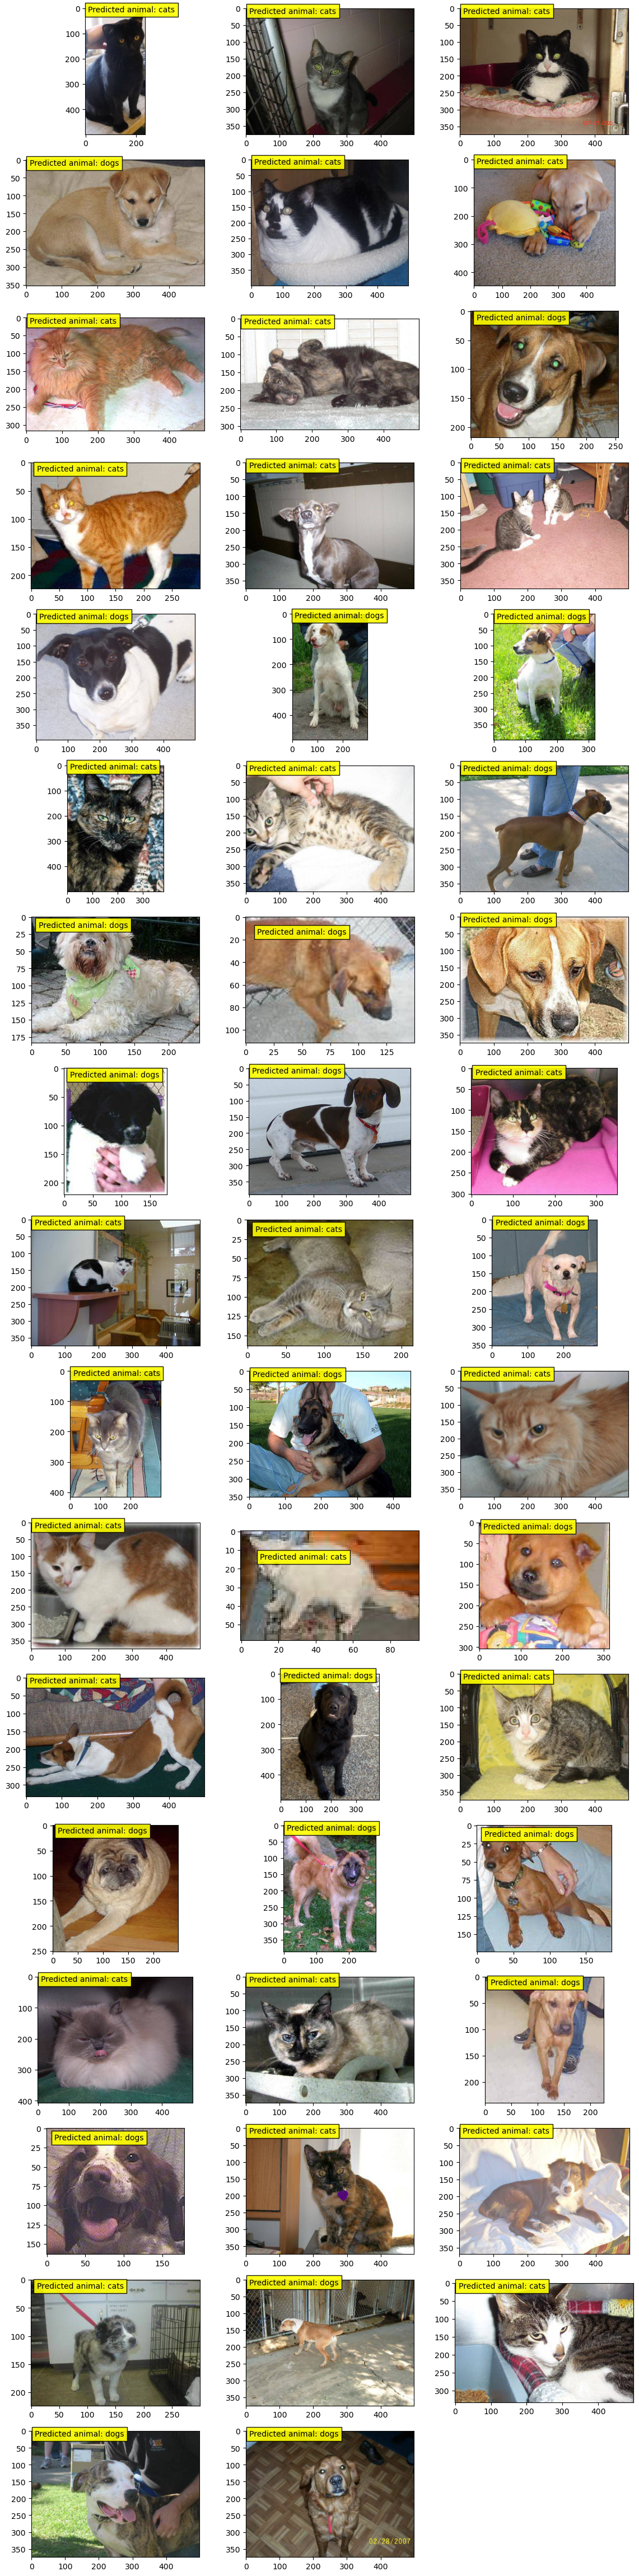

In [5]:
showClassificationResults(
    model=loadModelFromCheckpoint(), numberOfDemoSamples=50
)